# Exploring the Strava Graph with Py2neo

In this notebook we'll look at how to use [v4 of Py2neo](https://medium.com/neo4j/py2neo-v4-2bedc8afef2) to query a Neo4j database that contains running data from the Strava API.

First we'll import the libray and create a connection to a database running locally:

In [2]:
from py2neo import Graph
graph = Graph("bolt://localhost:7687", auth=("neo4j", "neo"))

## Find the most recent activities

Let's start by finding the 10 most recent runs along with the distance, time, and pace for each of them.
The following query returns this information:

In [3]:
recent_runs_df = graph.run("""\
MATCH (r:Run)
WITH r { .id, .startDate, .name, .movingTime, .distance,
           pace: duration({seconds: r.movingTime.seconds / r.distance * 1000})
         }
RETURN r.name, 
       apoc.date.format(r.startDate.epochSeconds, 's', 'MMM d yyyy') AS dateOfRun,
       r.distance, 
       apoc.date.format(r.movingTime.milliseconds, 'ms', 'HH:mm:ss') AS time,
       apoc.date.format(r.pace.milliseconds, "ms", "mm:ss") AS pacePerKm,
       r.startDate AS startDate
""").to_data_frame()
recent_runs_df.sort_values(by = ["startDate"], ascending=False).drop(["startDate"], axis=1).head(10)

,dateOfRun,pacePerKm,r.distance,r.name,time
605,Jun 13 2018,04:33,10780.2,Morning Run,00:49:11
604,Jun 11 2018,04:34,10035.8,Morning Run,00:45:53
603,Jun 9 2018,04:23,11043.2,Morning Run,00:48:29
602,Jun 8 2018,04:36,11281.2,Morning Run,00:51:57
586,Jun 6 2018,04:28,10884.9,Morning Run,00:48:38
585,Jun 4 2018,04:24,10030.5,Morning Run,00:44:14
584,Jun 2 2018,04:25,13039.8,Morning Run,00:57:41
601,Jun 1 2018,04:29,10701.7,Morning Run,00:48:02
600,May 30 2018,04:41,9828.4,Morning Run,00:46:06
599,May 28 2018,04:34,10193.0,Morning Run,00:46:42


We can visualise all the activites using matplotlib:

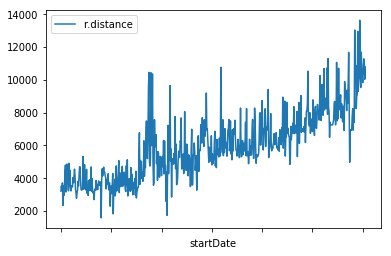

In [4]:
%matplotlib inline

recent_runs_df.plot(x="startDate", y="r.distance")

## Find the most recent activities in 2017

What if we want the find activities for a particular year?

In [5]:
graph.run("""\
MATCH (r:Run)
WHERE r.startDate.year = 2017
WITH r { .id, .startDate, .name, .movingTime, .distance,
           pace: duration({seconds: r.movingTime.seconds / r.distance * 1000})
         }
RETURN r.name, 
       apoc.date.format(r.startDate.epochSeconds, 's', 'MMM d yyyy') AS dateOfRun,
       r.distance, 
       apoc.date.format(r.movingTime.milliseconds, 'ms', 'HH:mm:ss') AS time,
       apoc.date.format(r.pace.milliseconds, "ms", "mm:ss") AS pacePerKm
ORDER BY r.startDate DESC
LIMIT 10
""").to_table()

r.name,dateOfRun,r.distance,time,pacePerKm
Evening Run,Dec 30 2017,7773.6,00:36:34,04:42
Morning Run,Dec 29 2017,10528.1,00:49:57,04:44
Lunch Run,Dec 27 2017,8579.2,00:41:08,04:47
Morning Run,Dec 25 2017,8093.7,00:38:32,04:45
Evening Run,Dec 23 2017,8094.3,00:38:58,04:48
Lunch Run,Dec 22 2017,7547.1,00:36:23,04:49
Morning Run,Dec 20 2017,8106.8,00:38:47,04:47
Morning Run,Dec 18 2017,8070.3,00:40:43,05:02
Afternoon Run,Dec 16 2017,8497.1,00:41:02,04:49
Morning Run,Dec 15 2017,7613.0,00:36:01,04:43


## What was the longest distance run each year?

In [6]:
graph.run("""\
MATCH (r:Run)
WITH r
ORDER BY r.startDate.year, r.distance DESC

WITH r.startDate.year AS year, collect(r)[0] AS longestRun

WITH year, 
     longestRun { .id, .startDate, .name, .movingTime, .distance,
                  pace: duration({seconds: longestRun.movingTime.seconds / longestRun.distance * 1000})
                }
RETURN year,
       longestRun.name, 
       apoc.date.format(longestRun.startDate.epochSeconds, 's', 'MMM d yyyy') AS dateOfRun,
       longestRun.distance, 
       apoc.date.format(longestRun.movingTime.milliseconds, 'ms', 'HH:mm:ss') AS time,
       apoc.date.format(longestRun.pace.milliseconds, "ms", "mm:ss") AS pacePerKm
ORDER BY year       
""").to_table()

year,longestRun.name,dateOfRun,longestRun.distance,time,pacePerKm
2014,Morning Run,Dec 3 2014,4703.9,00:28:18,06:00
2015,Morning Run,Dec 31 2015,9497.3,00:53:34,05:38
2016,Morning Run,Jan 2 2016,10457.9,00:56:57,05:26
2017,Morning Run,Jan 22 2017,10764.1,00:56:47,05:16
2018,Morning Run,May 19 2018,13635.2,01:01:27,04:30


## What was the quickest run each year?

In [7]:
quickest_df = graph.run("""\
MATCH (r:Run)
WITH r { .id, .startDate, .name, .movingTime, .distance,
         pace: duration({seconds: r.movingTime.seconds / r.distance * 1000})
       }
ORDER BY r.startDate.year, r.pace

WITH r.startDate.year AS year, collect(r)[0] AS longestRun

RETURN toInteger(year) AS year,
       longestRun.name, 
       apoc.date.format(longestRun.startDate.epochSeconds, 's', 'MMM d yyyy') AS dateOfRun,
       longestRun.distance, 
       apoc.date.format(longestRun.movingTime.milliseconds, 'ms', 'HH:mm:ss') AS time,
       apoc.date.format(longestRun.pace.milliseconds, "ms", "mm:ss") AS pacePerKm,
       apoc.math.round(toFloat(longestRun.pace.seconds) / 60, 2) AS pacePerKmFloat
ORDER BY year       
""").to_data_frame()
quickest_df

,dateOfRun,longestRun.distance,longestRun.name,pacePerKm,pacePerKmFloat,time,year
0,Nov 29 2014,4136.0,Morning Run,05:23,5.38,00:22:20,2014
1,Jul 5 2015,4360.9,Evening Run,04:42,4.70,00:20:31,2015
2,Jul 22 2016,4147.5,Morning Run,04:27,4.45,00:18:30,2016
3,Mar 26 2017,5355.8,Morning Run,04:36,4.60,00:24:42,2017
4,Jun 9 2018,11043.2,Morning Run,04:23,4.38,00:48:29,2018


In [8]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()

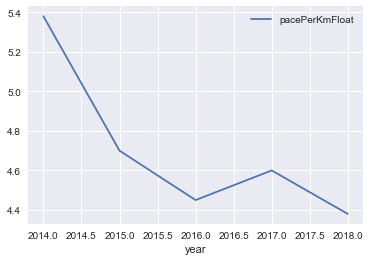

In [9]:
%matplotlib inline

quickest_df.plot(x="year", y="pacePerKmFloat")

## What were my quickest estimated runs?

In our graph we also have estimated attempts at different distances. 

When you submit an activity Strava generates predicted best times for a range of distances less than the total distance for that activity. For example if you submit an activity of 6,000 metres, Strava will generated estimated times for 5k, 2 miles, 1 mile, 1k, and 400m. 

These are my best estimated 10k attempts:

In [10]:
estimated_effort_query = """\
MATCH (distance:Distance {name: {distance}})<-[:DISTANCE]-(effort)<-[:DISTANCE_EFFORT]-(run)

WITH run { .id, .startDate, .distance,
           pace: duration({seconds: run.elapsedTime.seconds / run.distance * 1000})
         },
     effort { .elapsedTime,
              pace: duration({seconds: effort.elapsedTime.seconds / distance.distance * 1000  })
            }

RETURN run.id,
       apoc.date.format(run.startDate.epochSeconds, 's', 'MMM d yyyy') AS dateOfRun,
       apoc.date.format(effort.elapsedTime.milliseconds, 'ms', 'mm:ss') AS time,
       apoc.date.format(effort.pace.milliseconds, "ms", "mm:ss") AS pacePerKm,
       apoc.math.round(toFloat(effort.pace.seconds) / 60, 2) AS pacePerKmFloat,
       apoc.date.format(run.pace.milliseconds, "ms", "mm:ss") AS overallPacePerKm,
       run.distance AS totalDistance,
       run.startDate AS startDate
ORDER BY effort.elapsedTime
LIMIT {limit}
"""

df_10k = graph.run(estimated_effort_query, {"distance": "10k", "limit": 1000}).to_data_frame()
df_10k.head(10)

,dateOfRun,overallPacePerKm,pacePerKm,pacePerKmFloat,run.id,startDate,time,totalDistance
0,Jun 9 2018,04:24,04:24,4.40,1626636004,2018-06-09T10:28:32.000000000,44:05,11043.2
1,Jun 2 2018,04:25,04:25,4.42,1611168962,2018-06-02T06:23:45.000000000,44:12,13039.8
2,Jun 4 2018,04:27,04:27,4.45,1616050069,2018-06-04T05:14:16.000000000,44:35,10030.5
3,Jun 6 2018,04:28,04:28,4.47,1620188065,2018-06-06T05:18:47.000000000,44:49,10884.9
4,Jun 1 2018,04:29,04:29,4.48,1609355524,2018-06-01T05:17:44.000000000,44:59,10701.7
5,May 19 2018,04:31,04:30,4.50,1581401227,2018-05-19T09:55:00.000000000,45:02,13635.2
6,May 5 2018,04:33,04:32,4.53,1550422417,2018-05-05T09:12:45.000000000,45:26,11674.4
7,May 21 2018,04:33,04:34,4.57,1585759604,2018-05-21T05:22:11.000000000,45:41,10147.0
8,Jun 13 2018,04:34,04:34,4.57,1635264102,2018-06-13T05:33:31.000000000,45:48,10780.2
9,May 16 2018,04:34,04:34,4.57,1575082905,2018-05-16T05:15:13.000000000,45:49,10148.8


In [11]:
df_10k.sort_values(by=["startDate"]).drop("startDate", axis=1)

,dateOfRun,overallPacePerKm,pacePerKm,pacePerKmFloat,run.id,time,totalDistance
27,Jan 2 2016,05:42,05:42,5.70,461124609,57:03,10457.9
25,Jan 10 2016,05:23,05:24,5.40,467634177,54:08,10434.5
26,Jan 16 2016,05:29,05:28,5.47,471467618,54:46,10359.3
24,Jan 22 2017,05:17,05:17,5.28,840246999,52:50,10764.1
23,Dec 29 2017,04:46,04:46,4.77,1331484349,47:49,10528.1
15,Jan 27 2018,04:38,04:37,4.62,1378104750,46:17,11064.7
19,Feb 3 2018,04:41,04:40,4.67,1389752515,46:48,10705.9
22,Feb 17 2018,04:44,04:44,4.73,1412557204,47:27,10258.7
20,Mar 3 2018,04:43,04:42,4.70,1434535396,47:08,10690.9
21,Mar 14 2018,04:44,04:44,4.73,1452120577,47:26,10731.5


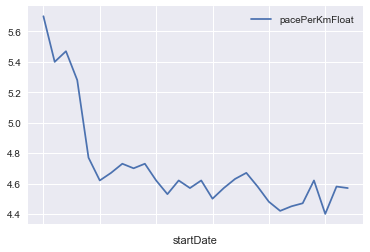

In [12]:
%matplotlib inline

df_10k.sort_values(by=["startDate"]).plot(x="startDate", y="pacePerKmFloat")

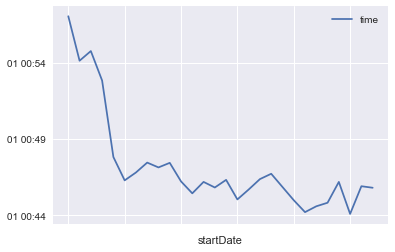

In [13]:
%matplotlib inline

import datetime

df_10k["time"] = df_10k["time"].apply(lambda x: datetime.datetime.strptime(x, "%M:%S"))

df_10k.sort_values(by=["startDate"]).plot(x="startDate", y="time")

We can run the same query passing in a different value to the `distance` parameter:

In [28]:
graph.run(estimated_effort_query, {"distance": "5k", "limit": 10}).to_data_frame().drop("startDate", axis=1)

,dateOfRun,overallPacePerKm,pacePerKm,pacePerKmFloat,run.id,time,totalDistance
0,Jun 2 2018,04:25,04:16,4.27,1611168962,21:24,13039.8
1,Jun 9 2018,04:24,04:18,4.30,1626636004,21:34,11043.2
2,Jan 20 2018,04:31,04:23,4.38,1366081623,21:55,8684.0
3,Jun 6 2018,04:28,04:24,4.40,1620188065,22:00,10884.9
4,Jun 4 2018,04:27,04:24,4.40,1616050069,22:01,10030.5
5,Mar 28 2018,04:28,04:27,4.45,1475714025,22:15,6949.4
6,May 19 2018,04:31,04:27,4.45,1581401227,22:15,13635.2
7,Jun 1 2018,04:29,04:27,4.45,1609355524,22:16,10701.7
8,Apr 2 2018,04:29,04:28,4.47,1485759514,22:20,7772.0
9,May 9 2018,04:29,04:28,4.47,1559310491,22:20,9019.7


In [29]:
graph.run(estimated_effort_query, {"distance": "1k", "limit": 10}).to_data_frame().drop("startDate", axis=1)

,dateOfRun,overallPacePerKm,pacePerKm,pacePerKmFloat,run.id,time,totalDistance
0,Jun 6 2018,04:28,03:58,3.97,1620188065,03:58,10884.9
1,Mar 26 2017,04:37,04:08,4.13,914796614,04:08,5355.8
2,May 2 2018,04:38,04:08,4.13,1544469717,04:08,8560.3
3,Jun 9 2018,04:24,04:08,4.13,1626636004,04:08,11043.2
4,Jan 20 2018,04:31,04:10,4.17,1366081623,04:10,8684.0
5,Apr 2 2018,04:29,04:10,4.17,1485759514,04:10,7772.0
6,Jun 1 2018,04:29,04:10,4.17,1609355524,04:10,10701.7
7,Jun 2 2018,04:25,04:10,4.17,1611168962,04:10,13039.8
8,May 25 2018,04:38,04:11,4.18,1594415412,04:11,11690.0
9,May 11 2018,04:38,04:12,4.20,1563554226,04:12,9084.8


# Combining estimated runs

What if I want to combine my efforts for multiple distances in a single row? 
Instead of returning a table of results we can use the `to_data_frame` function to return a Pandas DataFrame and then join those DataFrames:

In [16]:
import pandas as pd

In [17]:
df_5k = graph.run(estimated_effort_query, {"distance": "5k", "limit": 1000}).to_data_frame()
df_10k = graph.run(estimated_effort_query, {"distance": "10k", "limit": 1000}).to_data_frame()

cols = ["run.id", "dateOfRun_x", "time_x", "pacePerKm_x", "time_y", "pacePerKm_y"]

pd.merge(df_5k, df_10k, on="run.id")[cols].head(10)

,run.id,dateOfRun_x,time_x,pacePerKm_x,time_y,pacePerKm_y
0,1611168962,Jun 2 2018,21:24,04:16,44:12,04:25
1,1626636004,Jun 9 2018,21:34,04:18,44:05,04:24
2,1620188065,Jun 6 2018,22:00,04:24,44:49,04:28
3,1616050069,Jun 4 2018,22:01,04:24,44:35,04:27
4,1581401227,May 19 2018,22:15,04:27,45:02,04:30
5,1609355524,Jun 1 2018,22:16,04:27,44:59,04:29
6,1635264102,Jun 13 2018,22:20,04:28,45:48,04:34
7,1585759604,May 21 2018,22:27,04:29,45:41,04:34
8,1600870897,May 28 2018,22:30,04:30,45:51,04:35
9,1566256778,May 12 2018,22:30,04:30,46:11,04:37


In [18]:
df_1k = graph.run(estimated_effort_query, {"distance": "1k", "limit": 1000}).to_data_frame()
df_10k = graph.run(estimated_effort_query, {"distance": "10k", "limit": 1000}).to_data_frame()
df_1k_10k = pd.merge(df_1k, df_10k, on="run.id")[cols]

In [19]:
df_1k_10k.sort_values(by=['time_y']).head(10)

,run.id,dateOfRun_x,time_x,pacePerKm_x,time_y,pacePerKm_y
1,1626636004,Jun 9 2018,04:08,04:08,44:05,04:24
3,1611168962,Jun 2 2018,04:10,04:10,44:12,04:25
7,1616050069,Jun 4 2018,04:16,04:16,44:35,04:27
0,1620188065,Jun 6 2018,03:58,03:58,44:49,04:28
2,1609355524,Jun 1 2018,04:10,04:10,44:59,04:29
13,1581401227,May 19 2018,04:19,04:19,45:02,04:30
6,1550422417,May 5 2018,04:14,04:14,45:26,04:32
18,1585759604,May 21 2018,04:22,04:22,45:41,04:34
5,1635264102,Jun 13 2018,04:13,04:13,45:48,04:34
11,1575082905,May 16 2018,04:17,04:17,45:49,04:34


In [20]:
df_1k_10k.sort_values(by=['time_x']).head(10)

,run.id,dateOfRun_x,time_x,pacePerKm_x,time_y,pacePerKm_y
0,1620188065,Jun 6 2018,03:58,03:58,44:49,04:28
1,1626636004,Jun 9 2018,04:08,04:08,44:05,04:24
2,1609355524,Jun 1 2018,04:10,04:10,44:59,04:29
3,1611168962,Jun 2 2018,04:10,04:10,44:12,04:25
4,1594415412,May 25 2018,04:11,04:11,46:22,04:38
5,1635264102,Jun 13 2018,04:13,04:13,45:48,04:34
6,1550422417,May 5 2018,04:14,04:14,45:26,04:32
7,1616050069,Jun 4 2018,04:16,04:16,44:35,04:27
8,1566256778,May 12 2018,04:16,04:16,46:11,04:37
9,1631066785,Jun 11 2018,04:17,04:17,45:54,04:35


In [21]:
df_2mile = graph.run(estimated_effort_query, {"distance": "2 mile", "limit": 1000}).to_data_frame()
df_10k = graph.run(estimated_effort_query, {"distance": "10k", "limit": 1000}).to_data_frame()

df_2mile_10k = pd.merge(df_2mile, df_10k, on="run.id")[cols]

In [22]:
df_2mile_10k.sort_values(by=['time_x']).head(10)

,run.id,dateOfRun_x,time_x,pacePerKm_x,time_y,pacePerKm_y
0,1620188065,Jun 6 2018,13:38,04:14,44:49,04:28
1,1626636004,Jun 9 2018,13:42,04:15,44:05,04:24
2,1611168962,Jun 2 2018,13:47,04:16,44:12,04:25
3,1616050069,Jun 4 2018,14:08,04:23,44:35,04:27
4,1581401227,May 19 2018,14:13,04:24,45:02,04:30
5,1609355524,Jun 1 2018,14:14,04:25,44:59,04:29
6,1594415412,May 25 2018,14:15,04:25,46:22,04:38
7,1575082905,May 16 2018,14:17,04:26,45:49,04:34
8,1631066785,Jun 11 2018,14:17,04:26,45:54,04:35
9,1579256510,May 18 2018,14:18,04:26,46:19,04:37


In [23]:
multiple_efforts_query = """\
MATCH (d10k:Distance {name: {distance1}})<-[:DISTANCE]-(e10k)<-[:DISTANCE_EFFORT]-(run),
      (d5k:Distance {name: {distance2}})<-[:DISTANCE]-(e5k)<-[:DISTANCE_EFFORT]-(run)

WITH run { .id, .startDate, .distance,
           pace: duration({seconds: run.elapsedTime.seconds / run.distance * 1609.34})
         },
     e10k { .elapsedTime,
              pace: duration({seconds: e10k.elapsedTime.seconds / d10k.distance * 1000  })
            },
     e5k { .elapsedTime,
              pace: duration({seconds: e5k.elapsedTime.seconds / d5k.distance * 1000  })
            }            
      
RETURN apoc.date.format(run.startDate.epochSeconds, 's', 'MMM d yyyy') AS dateOfRun,
       apoc.date.format(e5k.elapsedTime.milliseconds, 'ms', 'mm:ss') AS time5k,
       apoc.date.format(e5k.pace.milliseconds, "ms", "mm:ss") AS pace5k,
apoc.date.format(e10k.elapsedTime.milliseconds, 'ms', 'mm:ss') AS time10k,

       apoc.date.format(e10k.pace.milliseconds, "ms", "mm:ss") AS pace10k,
       run.distance AS totalDistance 
ORDER BY e5k.pace
LIMIT 10
"""

graph.run(multiple_efforts_query, {"distance1": "10k", "distance2": "5k"}).to_table()

dateOfRun,time5k,pace5k,time10k,pace10k,totalDistance
Jun 2 2018,21:24,04:16,44:12,04:25,13039.8
Jun 9 2018,21:34,04:18,44:05,04:24,11043.2
Jun 6 2018,22:00,04:24,44:49,04:28,10884.9
Jun 4 2018,22:01,04:24,44:35,04:27,10030.5
May 19 2018,22:15,04:27,45:02,04:30,13635.2
Jun 1 2018,22:16,04:27,44:59,04:29,10701.7
Jun 13 2018,22:20,04:28,45:48,04:34,10780.2
May 21 2018,22:27,04:29,45:41,04:34,10147.0
May 28 2018,22:30,04:30,45:51,04:35,10193.0
May 12 2018,22:30,04:30,46:11,04:37,12963.9
